In [1]:
import numpy as np
from glob import glob
import os
import cv2
import json
import matplotlib.pyplot as plt

In [2]:
def load_dataset(data_dir):
    images = []
    labels = []
    img_dir = []
    for label in os.listdir(data_dir):
        for image_path in glob(os.path.join(data_dir, label, '*.jpg')):
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            img_dir.append(image_path)
            images.append(image)
            labels.append(label)
    return images, labels, img_dir

In [3]:
dataset_dir = 'dataset/seg'
images, labels, img_dir = load_dataset(dataset_dir)

# Database

In [4]:
import sqlite3
conn = sqlite3.connect("image_hist.db")
cursor = conn.cursor()

In [5]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS images (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    path TEXT,
    label TEXT,
    histogram BLOB
)
""")

In [6]:
def extract_histogram(image):
    histogram = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    histogram = cv2.normalize(histogram, histogram).flatten()
    histogram = histogram.flatten()
    return histogram

In [7]:
def preprocess_and_store(data_dir):
    for img, label, path in zip(images, labels, img_dir):
        hist = extract_histogram(img)
        hist_blob = hist.tobytes()
        cursor.execute("INSERT INTO images (path, label, histogram) VALUES (?, ?, ?)", (path, label, hist_blob))
    conn.commit()
    print("✅ Đã lưu toàn bộ histogram vào cơ sở dữ liệu.")

In [8]:
preprocess_and_store(dataset_dir)

✅ Đã lưu toàn bộ histogram vào cơ sở dữ liệu.


## test 

In [ ]:
def euclidean_distance(h1, h2):
    return np.linalg.norm(h1 - h2)

def find_similar_images(query_image_path, top_k=10):
    query_img = cv2.imread(query_image_path)
    query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
    query_hist = extract_histogram(query_img)

    cursor.execute("SELECT path, label, histogram FROM images")
    results = []
    for path, label, hist_blob in cursor.fetchall(): #knn
        hist = np.frombuffer(hist_blob, dtype=np.float32)
        dist = euclidean_distance(query_hist, hist)
        results.append((path, label, dist))

    # Sắp xếp theo khoảng cách tăng dần
    results.sort(key=lambda x: x[2])
    return results[:top_k]


In [53]:
result = find_similar_images('dataset\\seg_test\\sea\\20124.jpg', top_k=10)

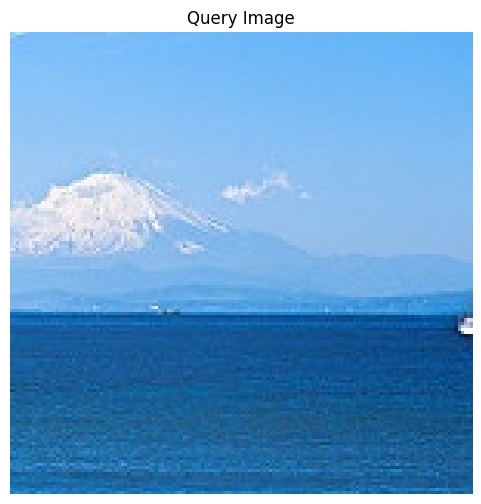

In [ ]:
plt.figure(figsize=(15,6))
plt.imshow(cv2.cvtColor(cv2.imread('dataset\\seg_test\\sea\\20124.jpg'), cv2.COLOR_BGR2RGB))
plt.title('Query Image')
plt.axis('off') 
plt.show()

In [54]:
print(result[0][0])
image_result = cv2.imread(result[0][0])

dataset/seg\sea\18598.jpg


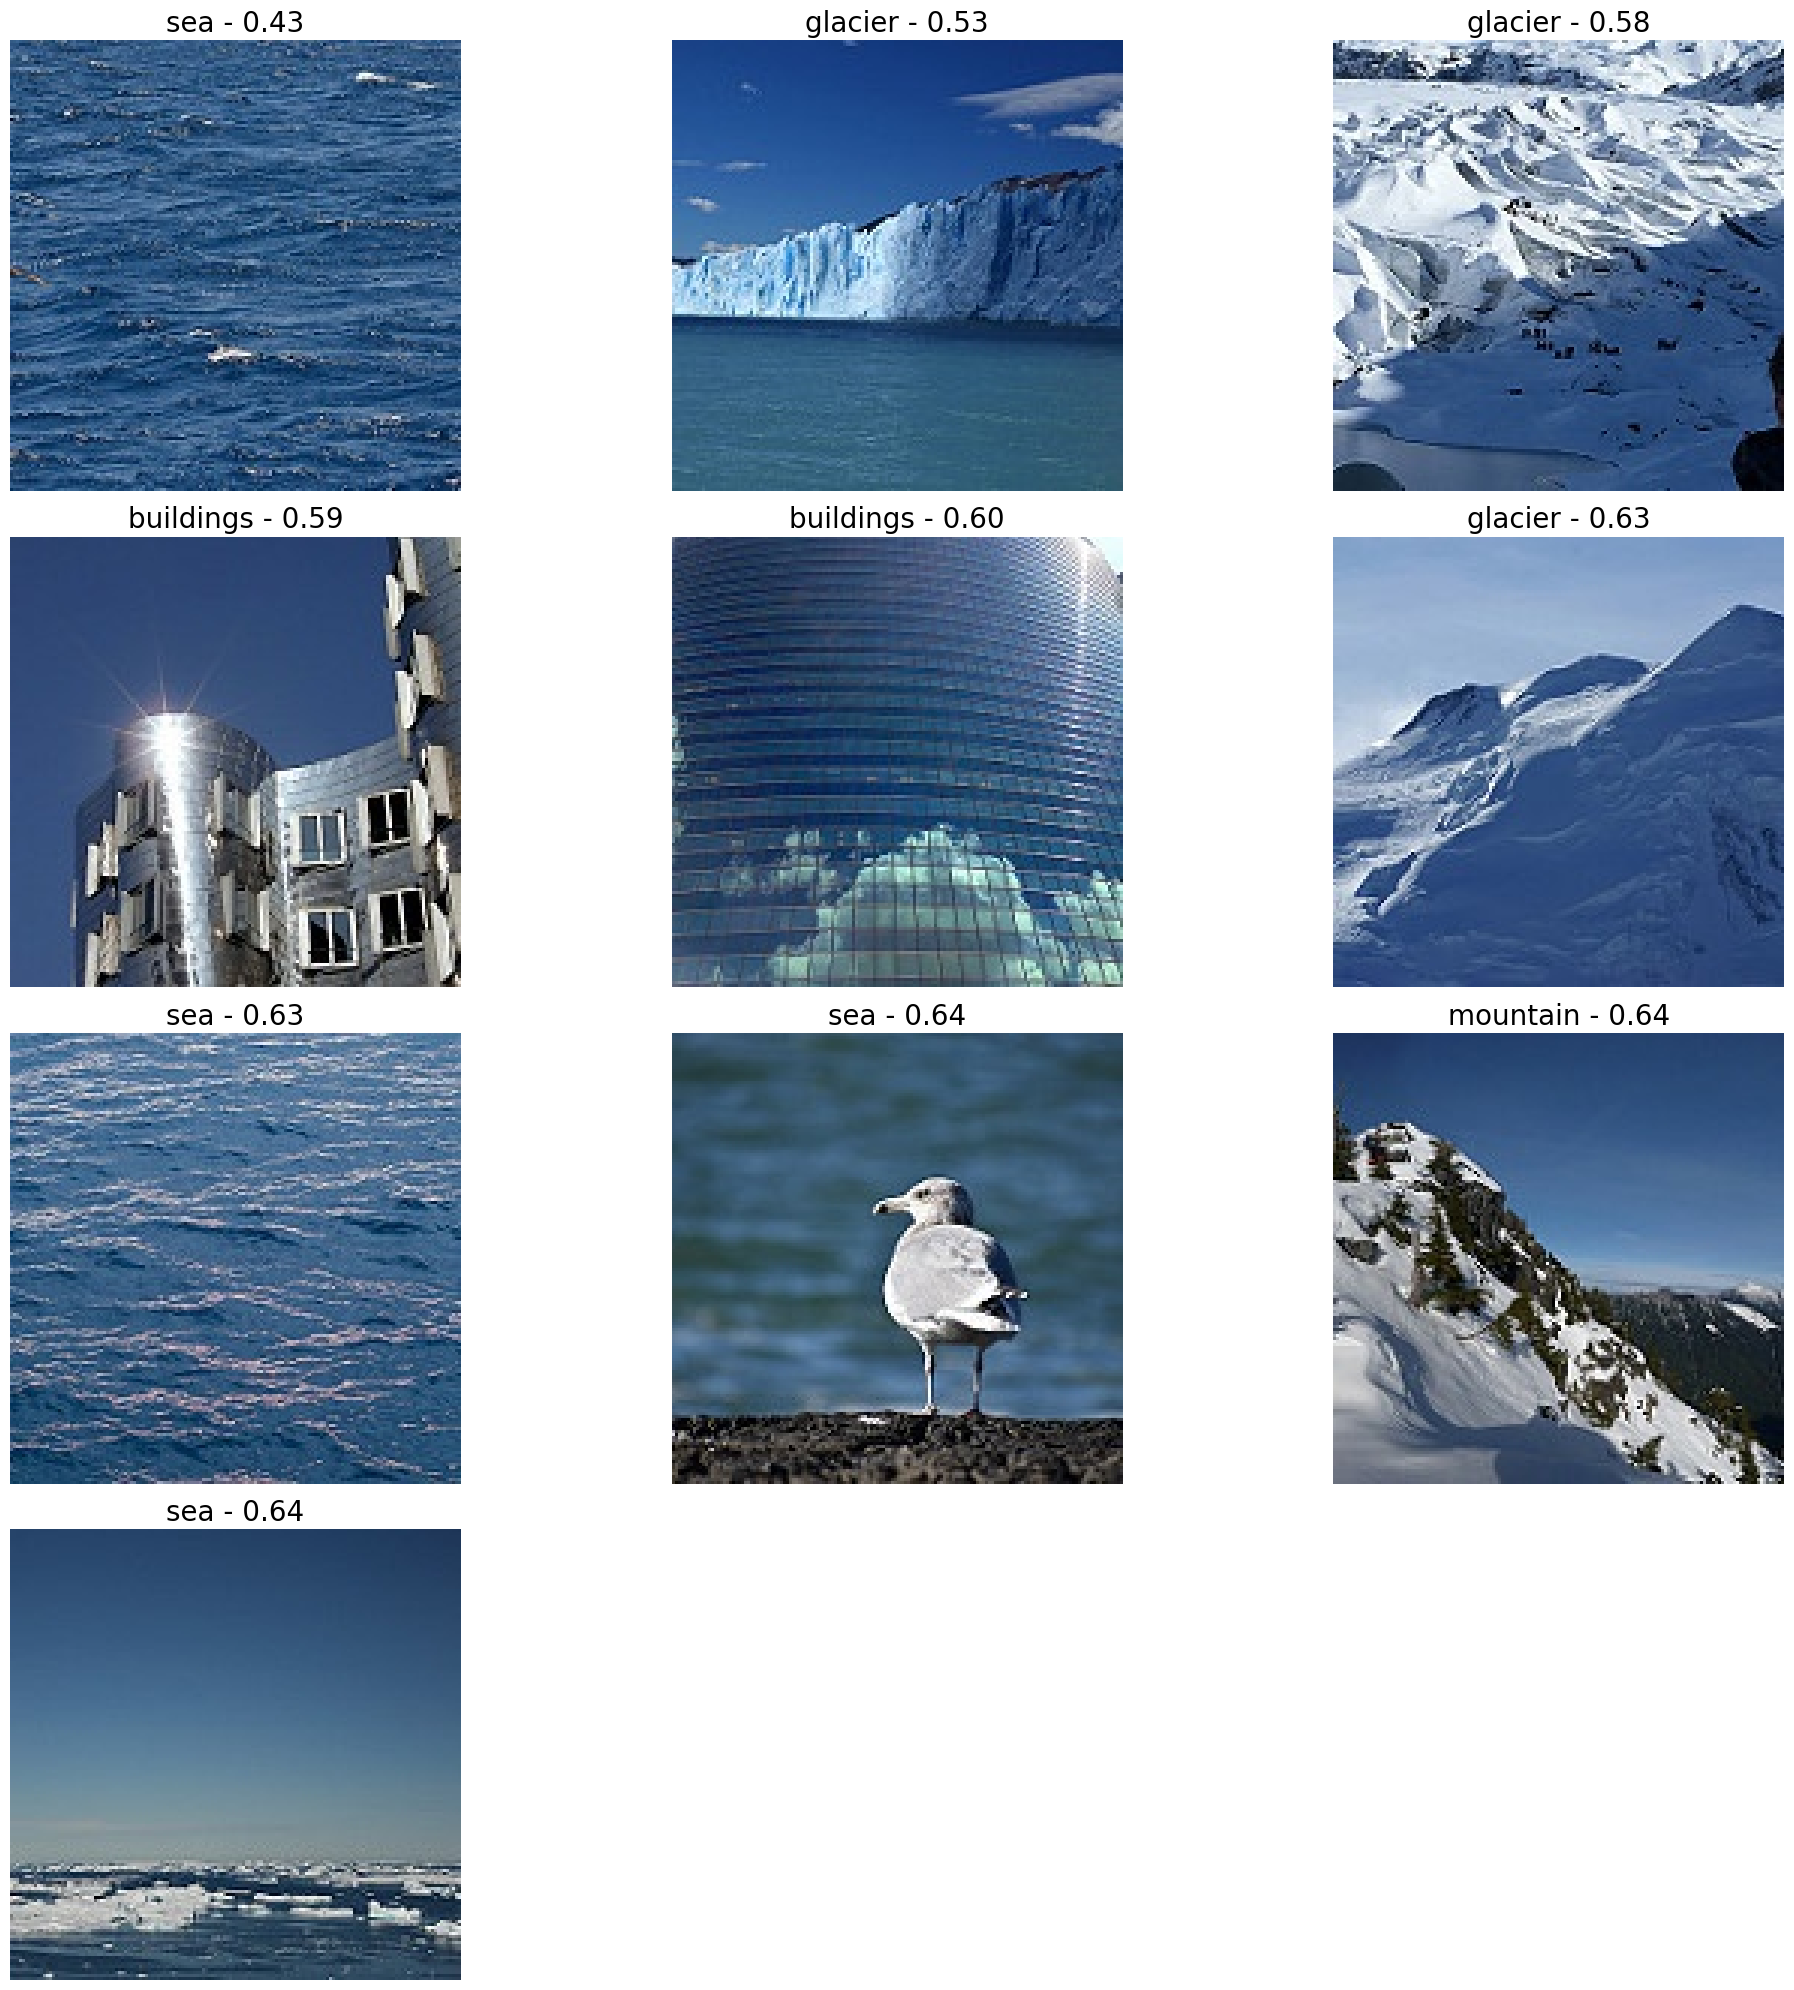

In [55]:
plt.figure(figsize=(20, 20))
for idx, (img_path, label, dist) in enumerate(result):
    plt.subplot(4, 3, idx+1)  # 5 hàng, 2 cột (ảnh to hơn)
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title(f"{label} - {dist:.2f}", fontsize=20)
    plt.axis("off")
plt.tight_layout()
